# Real Observations

Let's show that this works on pulsar data observed with NuSTAR:

In [1]:
%matplotlib notebook
import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np
import astropy.io.fits as fits

from stingray import Lightcurve, Powerspectrum, Crossspectrum
from stingray import AveragedPowerspectrum, AveragedCrossspectrum

/Users/danielahuppenkothen/work/repositories/stingraysoftware/stingray/stingray/utils.py:20: UserWarning: Numba not installed. Faking it
  warnings.warn("Numba not installed. Faking it")


Let's load some data:

In [2]:
f1 = fits.open("../data/nu10002013003A01_filt.evt")
toa1 = f1[1].data.field("TIME")

f2 = fits.open("../data/nu10002013003B01_filt.evt")
toa2 = f2[1].data.field("TIME")


/Users/danielahuppenkothen/work/repositories/stingraysoftware/stingray/stingray/utils.py:60: UserWarning: SIMON says: Bin sizes in input time array aren't equal throughout! This could cause problems with Fourier transforms. Please make the input time evenly sampled.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)


<IPython.core.display.Javascript object>


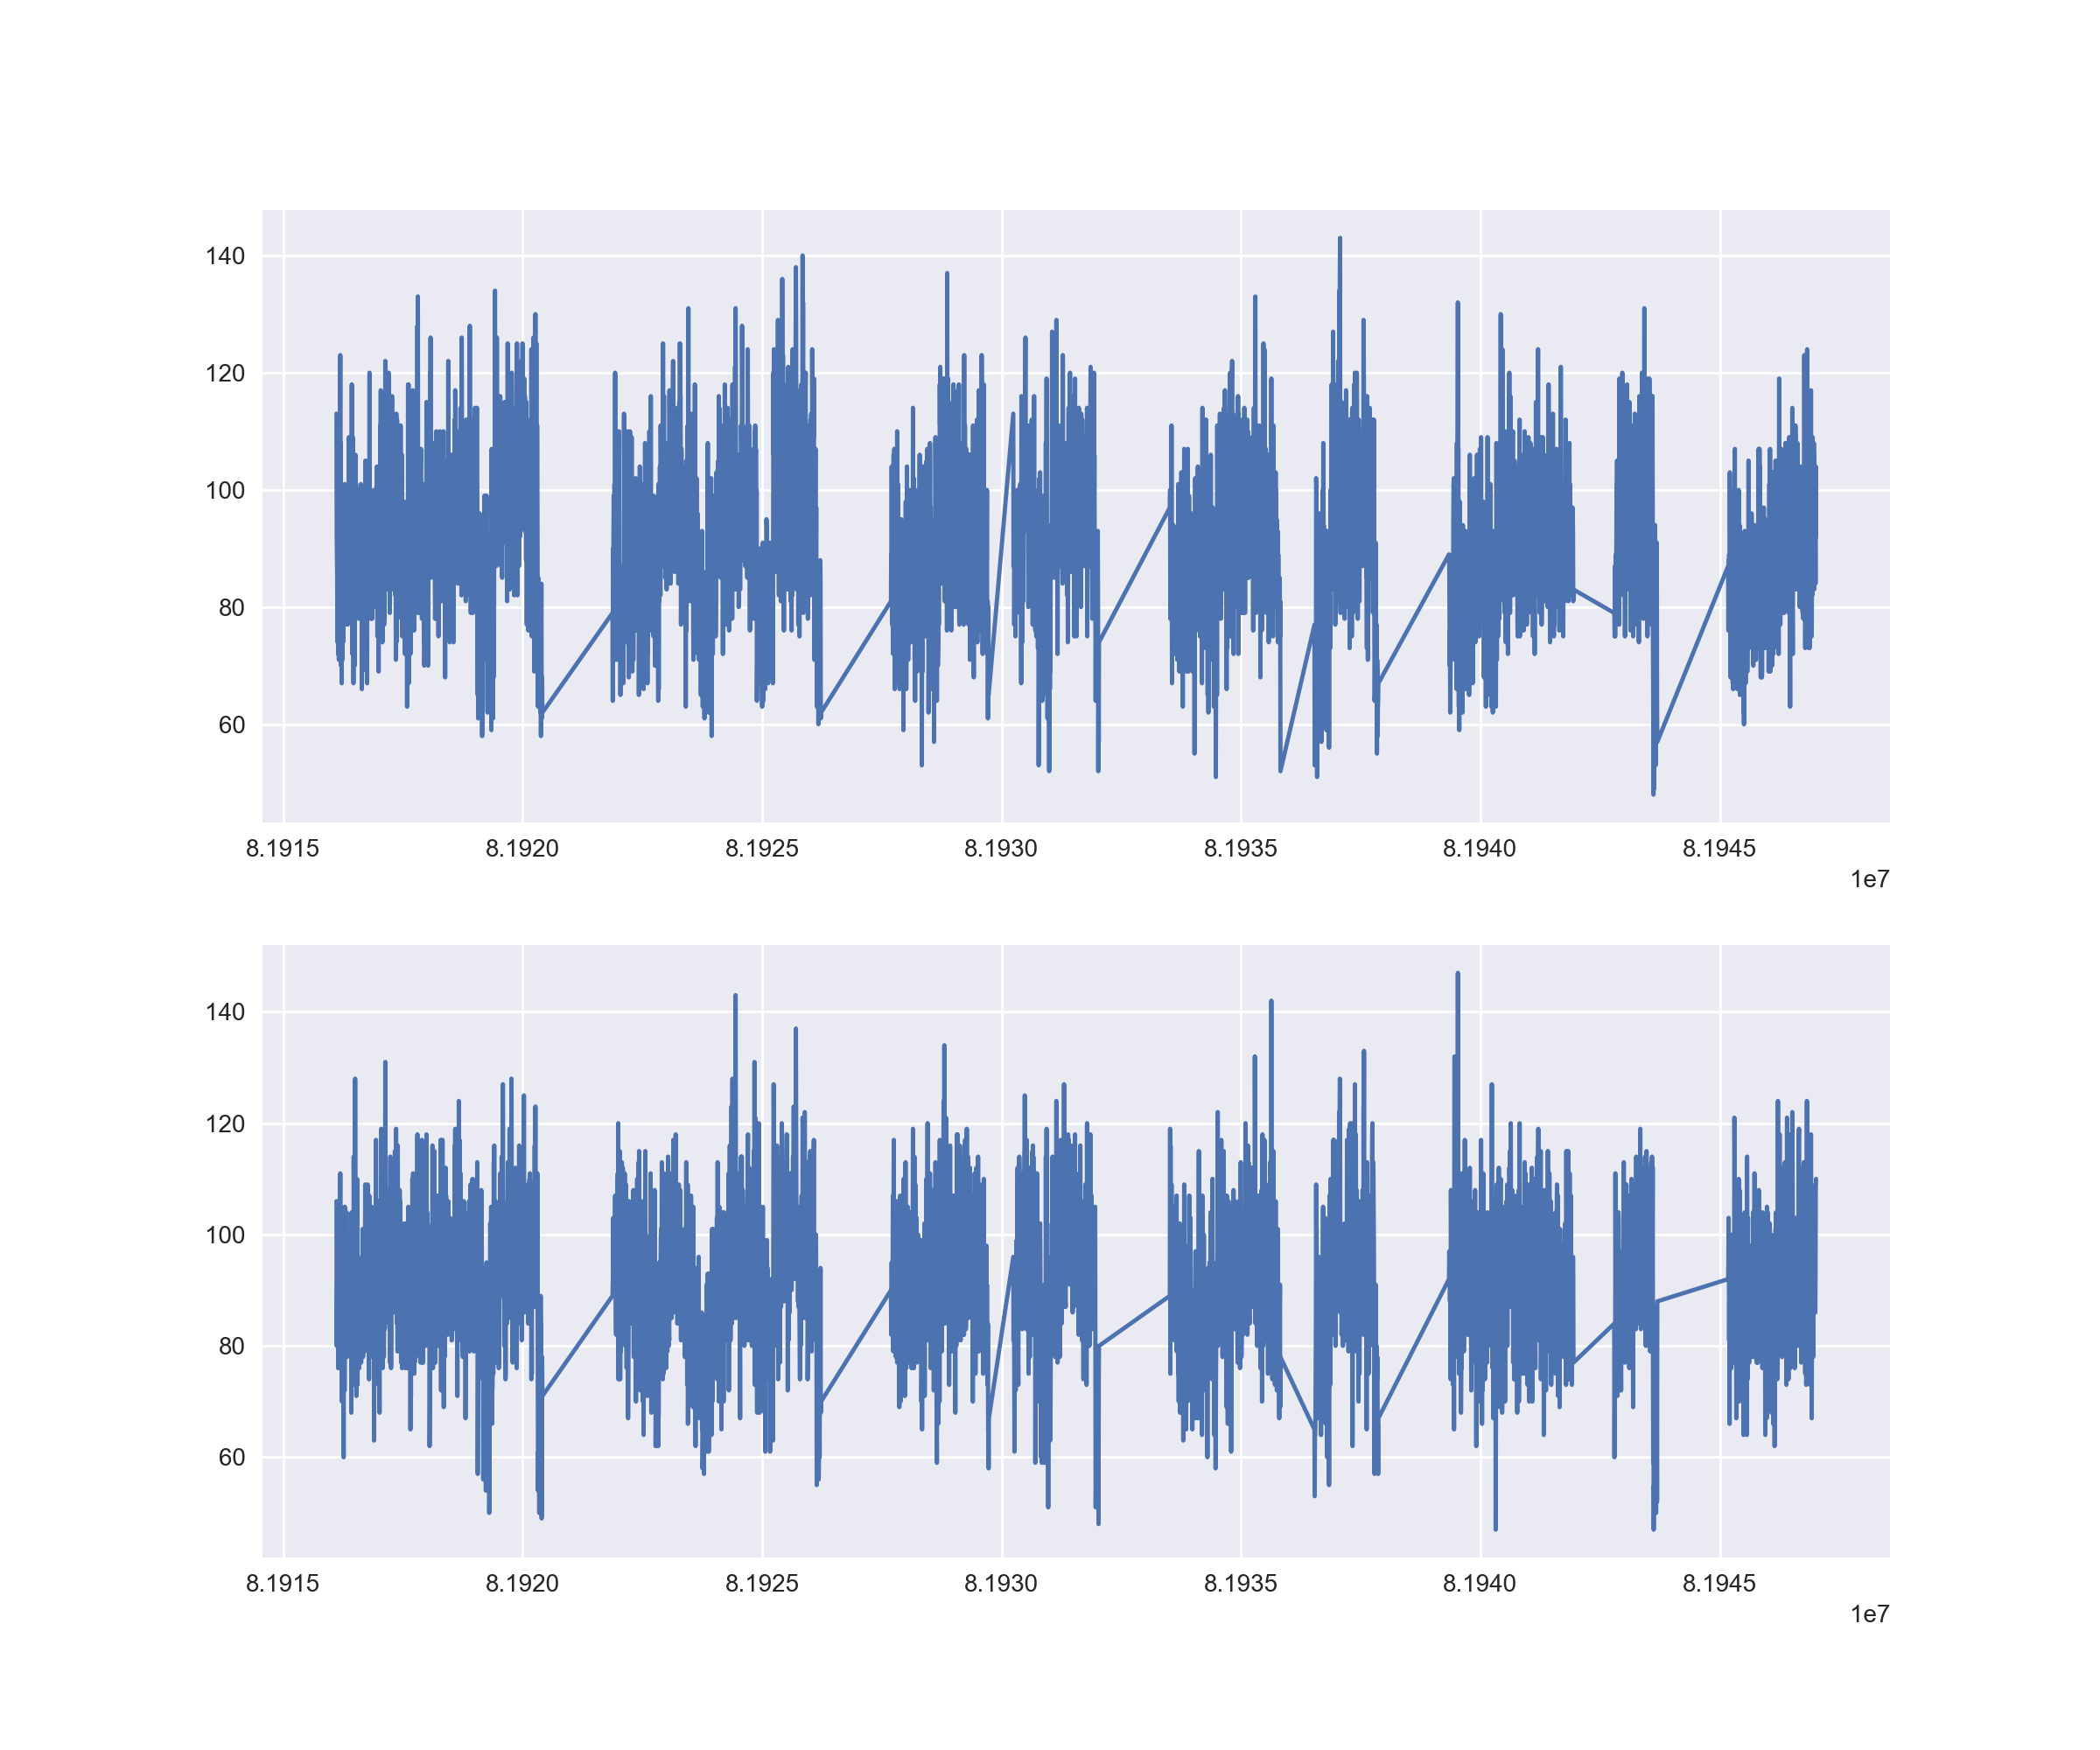

In [3]:
gti1 = np.array(list(zip(f1[2].data.field("START"), f1[2].data.field("STOP"))))
gti2 = np.array(list(zip(f2[2].data.field("START"), f2[2].data.field("STOP"))))

min_time = np.min(np.hstack([toa1, toa2]))
max_time = np.max(np.hstack([toa1, toa2]))

tseg = max_time - min_time

lc1 = Lightcurve.make_lightcurve(toa1, dt=5.0, tseg=tseg, tstart=min_time, gti=gti1)
lc2 = Lightcurve.make_lightcurve(toa2, dt=5.0, tseg=tseg, tstart=min_time, gti=gti2)

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))
ax1.plot(lc1.time, lc1.counts)
ax2.plot(lc2.time, lc2.counts)

<IPython.core.display.Javascript object>


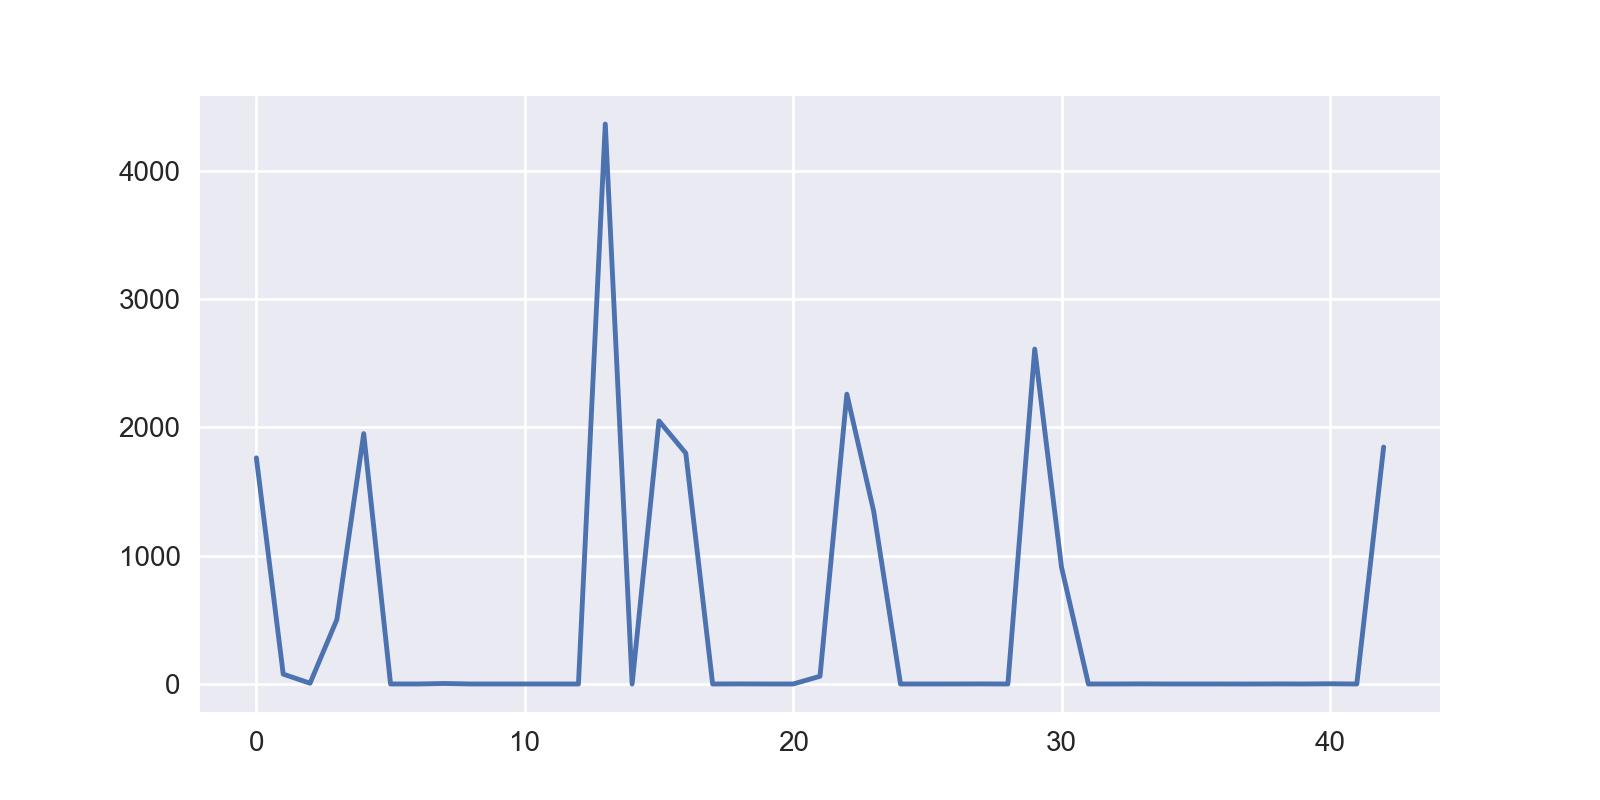

In [4]:
gti_length = gti1[:,1] - gti1[:,0]
plt.figure(figsize=(8,4))
plt.plot(gti_length)



In [7]:
gti_ind = np.where(gti_length == np.max(gti_length))[0][0]

In [8]:
tseg_new = gti1[gti_ind, 1] - gti1[gti_ind, 0]

In [10]:
import scipy.fftpack
import scipy.stats

In [41]:
lc1 = Lightcurve.make_lightcurve(toa1, dt=0.5/500.0, tseg=tseg_new, 
                                 tstart=gti1[gti_ind, 0], gti=np.atleast_2d(gti1[gti_ind]))
lc2 = Lightcurve.make_lightcurve(toa2, dt=0.5/500.0, tseg=tseg_new, 
                                 tstart=gti1[gti_ind, 0], gti=np.atleast_2d(gti1[gti_ind]))

fourier1 = scipy.fftpack.fft(lc1.counts)
fourier2 = scipy.fftpack.fft(lc2.counts)

freqs = scipy.fftpack.fftfreq(lc1.n, lc1.dt)

fourier1 = fourier1[freqs>0]
fourier2 = fourier2[freqs>0]
freqs = freqs[freqs>0]

In [42]:
lc1.tseg

4365.2740000039339

Let's find some minimum frequency to use for the distributions just so that I don't have the pulsar signal in my noise:

In [43]:
fmin = freqs.searchsorted(200.0)

In [44]:
variance1 = np.sum(lc1.counts)/2.0
variance2 = np.sum(lc2.counts)/2.0
gauss1 = scipy.stats.norm(0.0, np.sqrt(variance1))
gauss2 = scipy.stats.norm(0.0, np.sqrt(variance2))

<IPython.core.display.Javascript object>


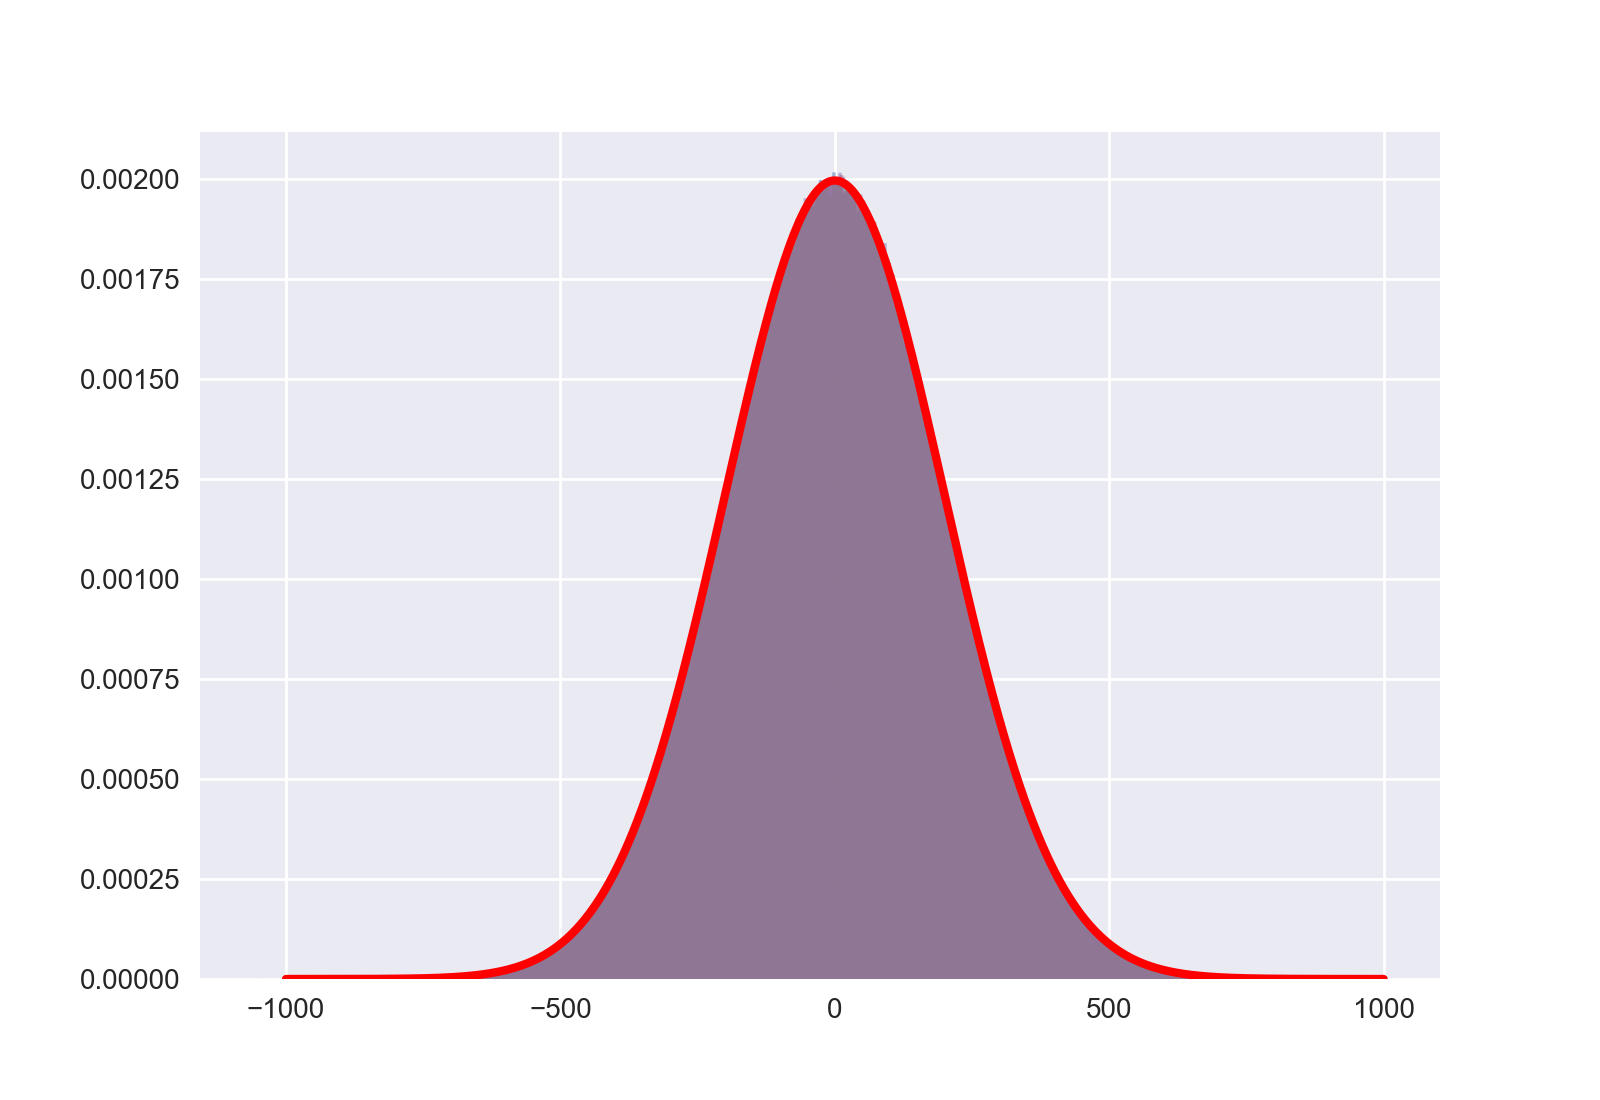

In [45]:
plt.figure()
plt.hist(fourier1.real[fmin:], histtype="stepfilled", bins=300, alpha=0.5, normed=True)
plt.hist(fourier1.imag[fmin:], histtype="stepfilled", bins=300, alpha=0.5, normed=True)
plt.hist(fourier2.real[fmin:], histtype="stepfilled", bins=300, alpha=0.5, normed=True)
plt.hist(fourier2.imag[fmin:], histtype="stepfilled", bins=300, alpha=0.5, normed=True);

xgauss = np.linspace(-1000, 1000, 1000)
pdf_gauss = gauss1.pdf(xgauss)

plt.plot(xgauss, pdf_gauss, lw=3, color="red")

In [46]:
np.mean(fourier1.real[fmin:])

0.10291764223310099

In [47]:
np.mean(fourier2.real[fmin:])

-0.021266777756383443

In [48]:
variance1 = np.sum(lc1.counts)/2.0
variance2 = np.sum(lc2.counts)/2.0
gauss1 = scipy.stats.norm(0.0, np.sqrt(variance1))
gauss2 = scipy.stats.norm(0.0, np.sqrt(variance2))

print(scipy.stats.kstest(fourier1.real[fmin:], gauss1.cdf))
print(scipy.stats.kstest(fourier1.imag[fmin:], gauss1.cdf))
print(scipy.stats.kstest(fourier2.real[fmin:], gauss2.cdf))
print(scipy.stats.kstest(fourier2.imag[fmin:], gauss2.cdf))

KstestResult(statistic=0.0011510832273388116, pvalue=0.062209315424743603)
KstestResult(statistic=0.00082231742454150214, pvalue=0.33861834819106063)
KstestResult(statistic=0.00081421861901700976, pvalue=0.3503892657133279)
KstestResult(statistic=0.00091253355172471462, pvalue=0.2255272629337074)


Hmmm, that doesn't look as Gaussian as I think it should be. I think that's because I have a periodic signal in there which takes up part of the variance.

In [49]:
ps1 = Powerspectrum(lc1, norm="leahy")
ps2 = Powerspectrum(lc2, norm="leahy")

<IPython.core.display.Javascript object>


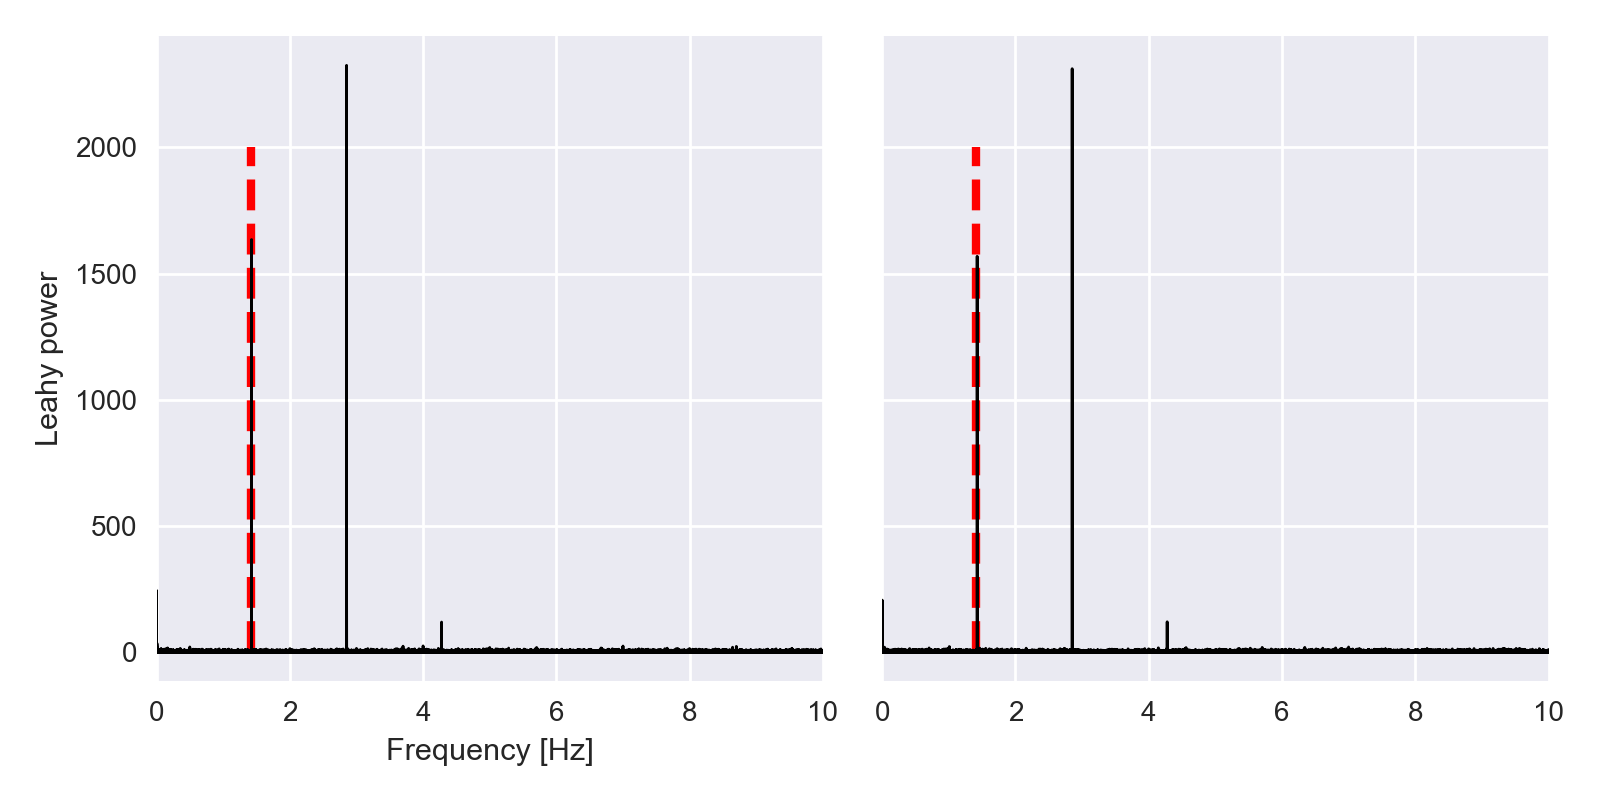

In [50]:
pulsar_freq = 1.4136308014

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8,4), sharey=True)
ax1.plot(ps1.freq, ps1.power, lw=1, color="black")
ax2.plot(ps2.freq, ps2.power, lw=1, color="black")

ax1.vlines(pulsar_freq, 0, 2000, lw=3, color="red", linestyle="dashed")
ax2.vlines(pulsar_freq, 0, 2000, lw=3, color="red", linestyle="dashed")

ax1.set_xlabel("Frequency [Hz]")
ax1.set_ylabel("Leahy power")

ax1.set_xlim(0,10)
ax2.set_xlim(0,10)

plt.tight_layout()

Okay, let's instead compute the cospectrum of this lightcurve:

In [53]:
cps = Crossspectrum(lc1, lc2)

/Users/danielahuppenkothen/work/repositories/stingraysoftware/stingray/stingray/utils.py:60: UserWarning: SIMON says: Errorbars on cross spectra are not thoroughly tested. Please report any inconsistencies.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)


<IPython.core.display.Javascript object>


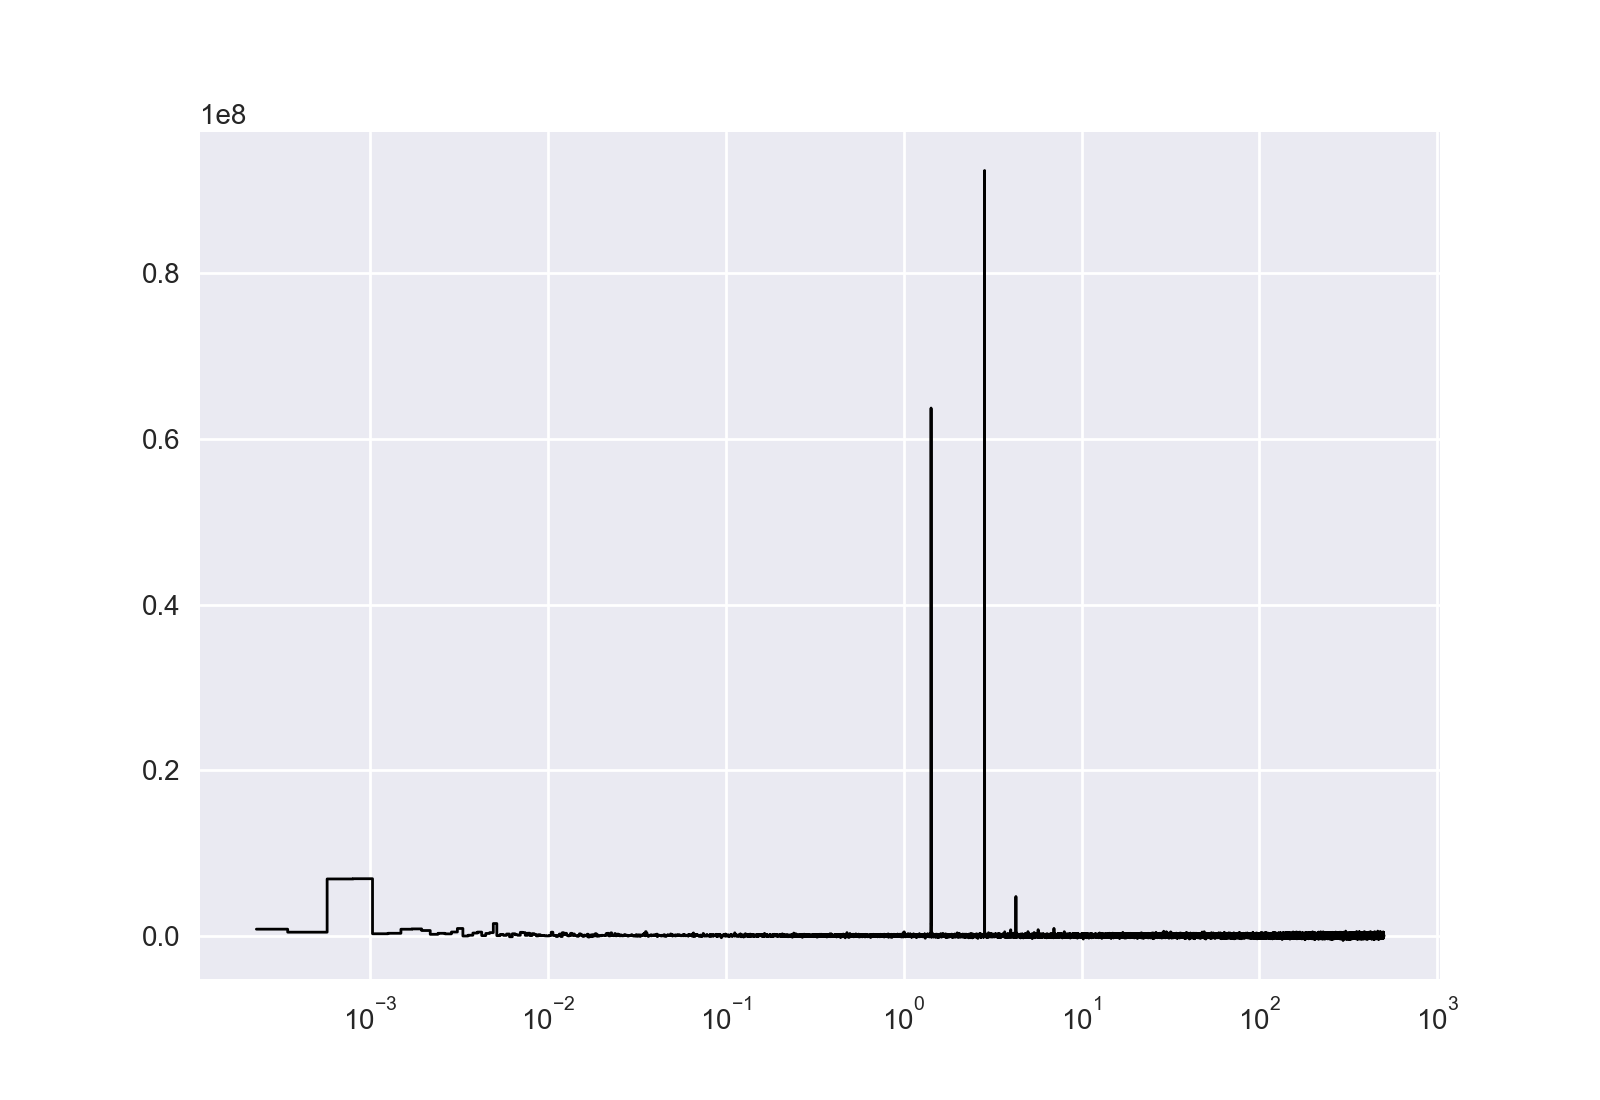

In [54]:
plt.figure()
plt.semilogx(cps.freq, cps.power.real, lw=1, color="black", linestyle="steps-mid")

Let's look at the distribution of cospectral powers:

<IPython.core.display.Javascript object>


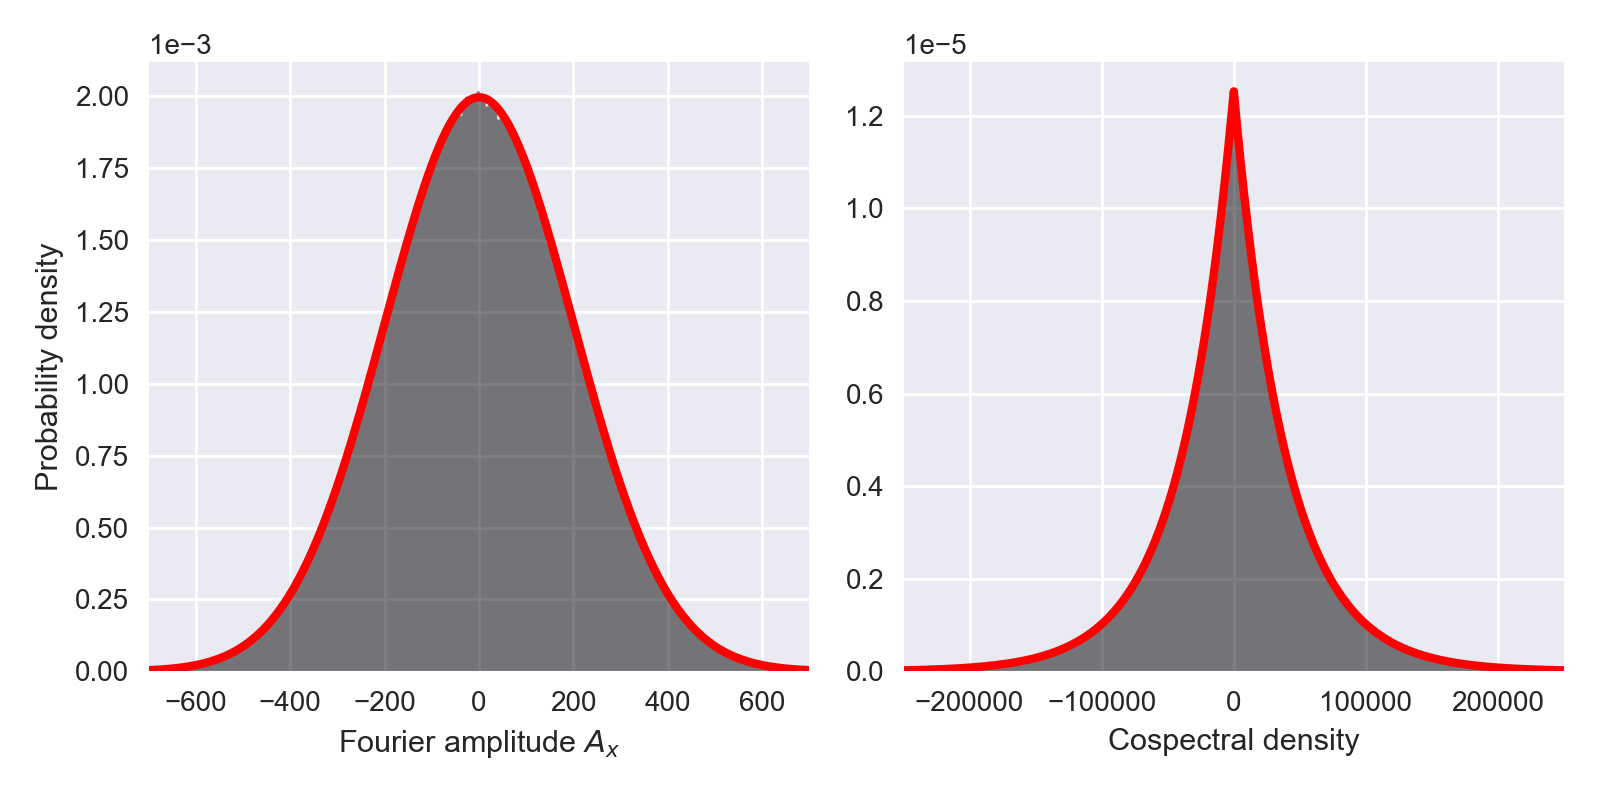

In [55]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8,4))

ax1.hist(fourier1.real[fmin:], histtype="stepfilled", bins=300, 
         alpha=0.5, normed=True, color="black")
#ax1.hist(fourier1.imag[fmin:], histtype="stepfilled", bins=300, alpha=0.5, normed=True)
#ax1.hist(fourier2.real[fmin:], histtype="stepfilled", bins=300, alpha=0.5, normed=True)
#ax1.hist(fourier2.imag[fmin:], histtype="stepfilled", bins=300, alpha=0.5, normed=True)

xgauss = np.linspace(-1000, 1000, 1000)
pdf_gauss = gauss1.pdf(xgauss)

ax1.plot(xgauss, pdf_gauss, lw=3, color="red")
ax1.set_xlim(-700, 700)

ax1.set_xlabel(r"Fourier amplitude $A_x$")
ax1.set_ylabel("Probability density")
ax1.ticklabel_format(style='sci',scilimits=(-3,4),axis='y')


ax2.hist(cps.power.real[fmin:], histtype="stepfilled", 
         bins=300, alpha=0.5, normed=True, color="black")

laplace = scipy.stats.laplace(loc=0, scale=np.sqrt(variance1*variance2))
xlaplace = np.linspace(-5e5, 5e5, 10000)
pdf_laplace = laplace.pdf(xlaplace)

ax2.plot(xlaplace, pdf_laplace, lw=3, color="red")
ax2.set_xlim(-2.5e5, 2.5e5)
ax2.set_xlabel("Cospectral density")
ax2.ticklabel_format(style='sci',scilimits=(-3,4),axis='y')

plt.tight_layout()

plt.savefig("../paper/nustar_dist.png")

In [56]:
scipy.stats.kstest(cps.power.real[fmin:], laplace.cdf)

KstestResult(statistic=0.0011732980305687035, pvalue=0.054340657542550602)

Let's look at the light curve of the first 100 seconds or so:

In [69]:
gti = gti1[gti_ind]

In [184]:
tseg = 20.0

min_ind1 = toa1.searchsorted(gti[0])
min_ind2 = toa2.searchsorted(gti[0])

max_ind1 = toa1.searchsorted(gti[0]+tseg)
max_ind2 = toa2.searchsorted(gti[0]+tseg)

toa1_temp = toa1[min_ind1:max_ind1]
toa2_temp = toa2[min_ind2:max_ind2]

In [185]:
lc1 = Lightcurve.make_lightcurve(toa1_temp, dt=0.5/500.0, tseg=tseg, 
                                 tstart=gti[0], gti=np.atleast_2d(gti))
lc2 = Lightcurve.make_lightcurve(toa2_temp, dt=0.5/500.0, tseg=tseg, 
                                 tstart=gti[0], gti=np.atleast_2d(gti))


In [186]:
cps = Crossspectrum(lc1, lc2, norm="leahy")

/Users/danielahuppenkothen/work/repositories/stingraysoftware/stingray/stingray/utils.py:60: UserWarning: SIMON says: Errorbars on cross spectra are not thoroughly tested. Please report any inconsistencies.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)


In [187]:
std1 = np.sqrt(np.sum(lc1.counts)/2.0)
std2 = np.sqrt(np.sum(lc2.counts)/2.0)

In [188]:
lapl = scipy.stats.laplace(0, 1.0)
lapl_ppf = lapl.isf(0.01/len(cps.freq))


In [189]:
lapl_ppf

13.122263372375961

<IPython.core.display.Javascript object>


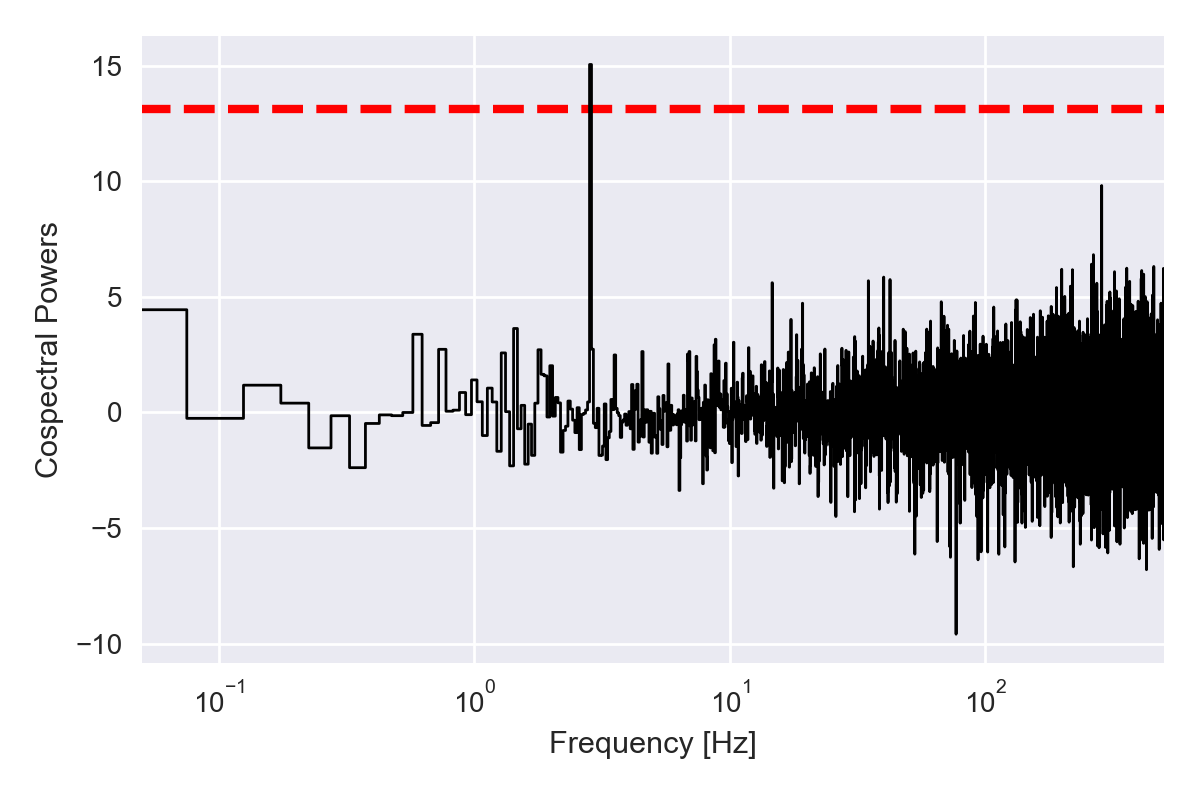

In [190]:
fig, ax = plt.subplots(1, 1, figsize=(6,4))
ax.semilogx(cps.freq, cps.power.real, lw=1, color="black", linestyle="steps-mid")
ax.hlines(lapl_ppf, 1e-2, 1000, lw=3, color="red", linestyle="dashed")
ax.set_xlim(cps.freq[0], cps.freq[-1])

ax.set_xlabel("Frequency [Hz]")
ax.set_ylabel("Cospectral Powers")
plt.tight_layout()

plt.savefig("../paper/nustar_cospectrum.png", format="png")

Let's now make an averaged cospectrum:

In [193]:
tseg = 200.0

min_ind1 = toa1.searchsorted(gti[0])
min_ind2 = toa2.searchsorted(gti[0])

max_ind1 = toa1.searchsorted(gti[0]+tseg)
max_ind2 = toa2.searchsorted(gti[0]+tseg)

toa1_temp = toa1[min_ind1:max_ind1]
toa2_temp = toa2[min_ind2:max_ind2]

In [194]:
lc1 = Lightcurve.make_lightcurve(toa1_temp, dt=0.5/500.0, tseg=tseg, 
                                 tstart=gti[0], gti=np.atleast_2d(gti))
lc2 = Lightcurve.make_lightcurve(toa2_temp, dt=0.5/500.0, tseg=tseg, 
                                 tstart=gti[0], gti=np.atleast_2d(gti))

In [195]:
avg_cps = AveragedCrossspectrum(lc1, lc2, segment_size=20.0, norm="leahy")

/Users/danielahuppenkothen/work/repositories/stingraysoftware/stingray/stingray/utils.py:60: UserWarning: SIMON says: Errorbars on cross spectra are not thoroughly tested. Please report any inconsistencies.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)


In [196]:
def averaged_cospectra_cdf(xcoord, n):
    cdf = np.zeros_like(xcoord)

    for i,x in enumerate(xcoord):
        prefac_bottom1 = scipy.misc.factorial(n-1)
        #print("x: " + str(x))
        for j in range(n):
            #print("j: " + str(j))
            prefac_top = scipy.misc.factorial(n-1+j)
            prefac_bottom2 = scipy.misc.factorial(n-1-j) * scipy.misc.factorial(j)
            prefac_bottom3 = 2.0**(n+j)
            
            prefac = prefac_top / (prefac_bottom1 * prefac_bottom2 * prefac_bottom3)
            
            #print("prefac: " + str(prefac))
            gf = -j + n
            
            #print("gamma_fac: " + str(gf))
            first_fac = scipy.special.gamma(gf)
            #print("first_fac: " + str(first_fac))
            if x >= 0:    
                second_fac = scipy.special.gammaincc(gf, n*x) * first_fac
                #print("second_fac: " + str(second_fac))
                fac = 2.0*first_fac - second_fac
            else:
                fac = scipy.special.gammaincc(gf, -n*x) * first_fac
            
            #print("fac: " + str(fac))
            #print("prefac * fac: " + str(prefac*fac) + "\n")
            cdf[i] += (prefac * fac)
                
    return cdf
        

In [198]:
avg_cps.m

10

In [221]:
cdf_x = np.linspace(-4, 4, 5000)

In [222]:
cdf = averaged_cospectra_cdf(cdf_x, avg_cps.m)

<IPython.core.display.Javascript object>


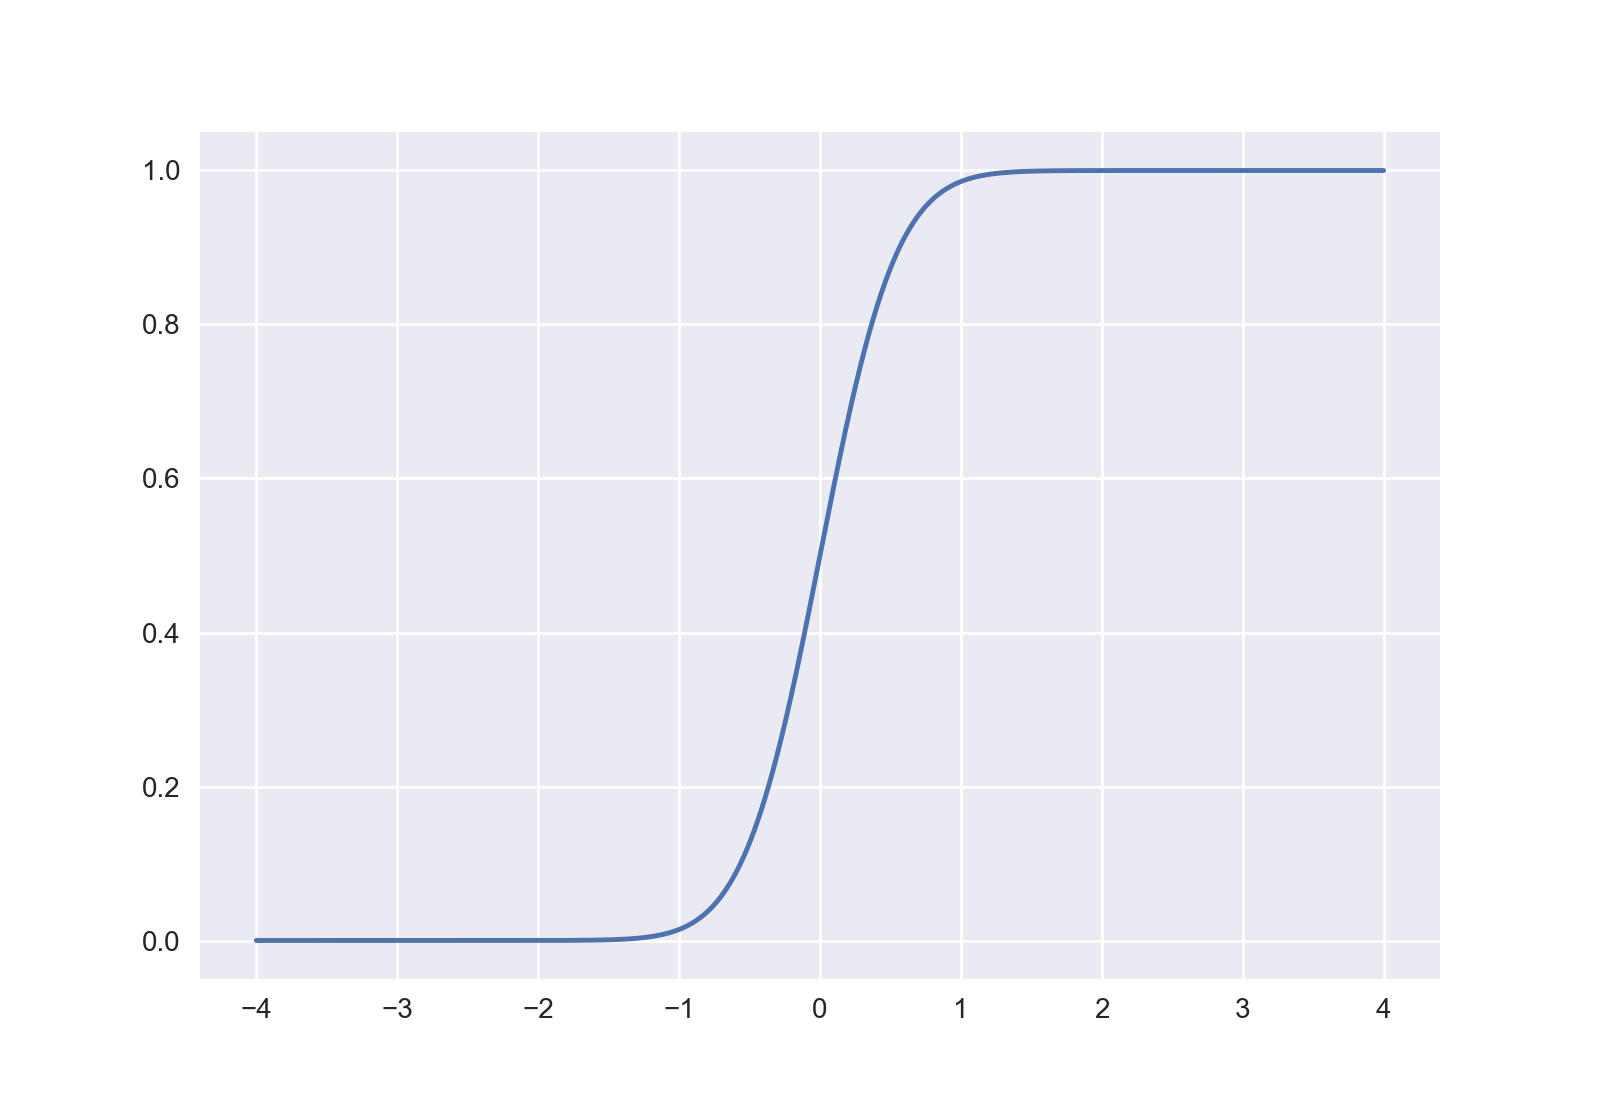

In [223]:
plt.figure()
plt.plot(cdf_x, cdf)

In [226]:
1.0 - 0.01/len(avg_cps.freq)

0.99999899989999

In [227]:
cdf_ind = cdf.searchsorted(1.0 - 0.01/len(avg_cps.freq))

In [228]:
cdf_ind

4073

In [229]:
cdf[cdf_ind]

0.99999900144878862

In [230]:
thres = cdf_x[cdf_ind]

<IPython.core.display.Javascript object>


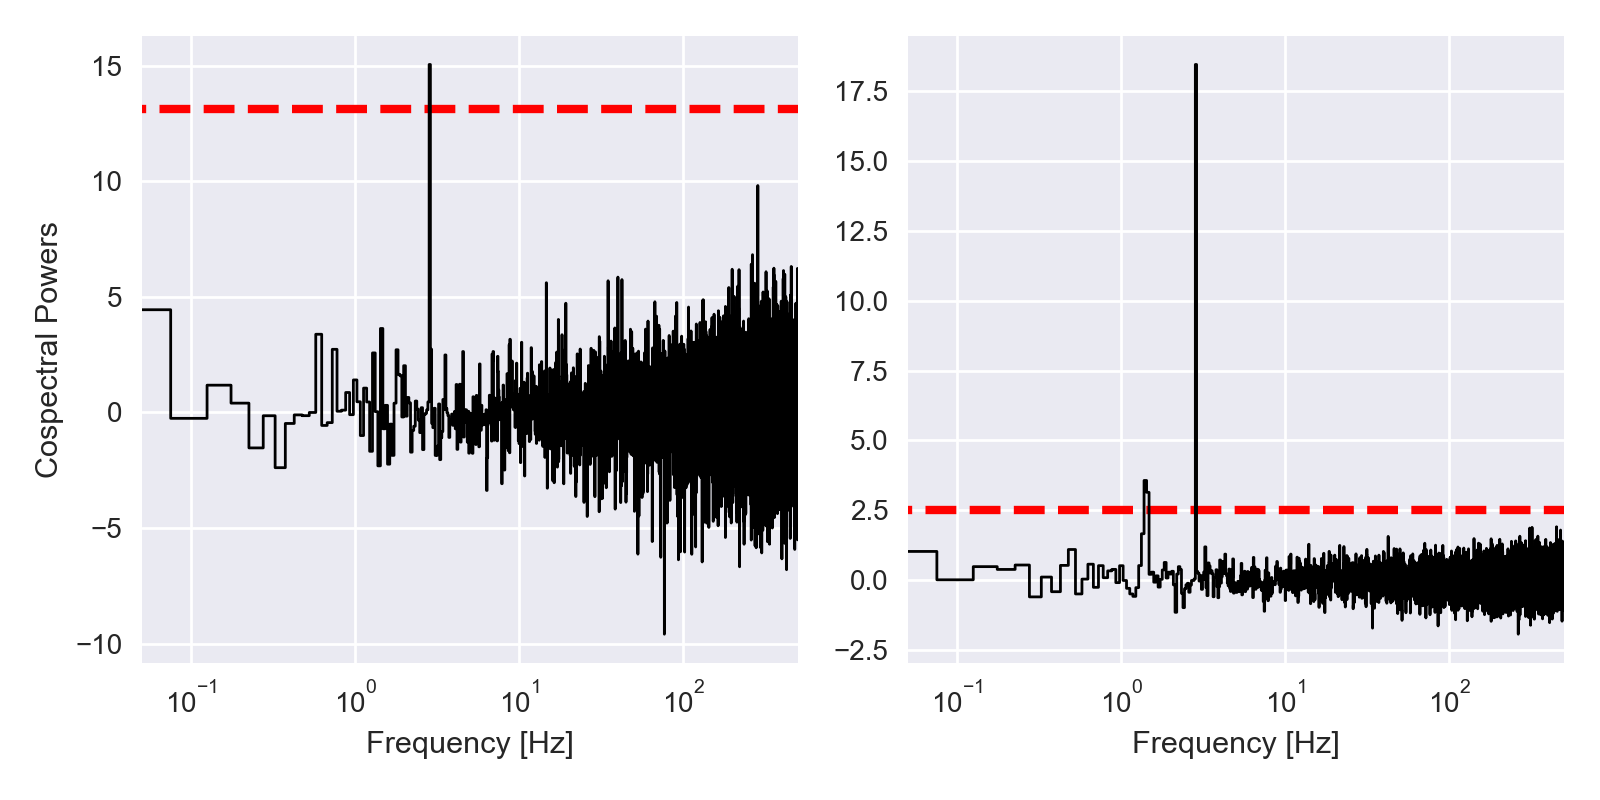

In [232]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8,4))
ax1.semilogx(cps.freq, cps.power.real, lw=1, color="black", linestyle="steps-mid")
ax1.hlines(lapl_ppf, 1e-2, 1000, lw=3, color="red", linestyle="dashed")
ax1.set_xlim(cps.freq[0], cps.freq[-1])

ax1.set_xlabel("Frequency [Hz]")
ax1.set_ylabel("Cospectral Powers")

ax2.semilogx(avg_cps.freq, avg_cps.power.real, lw=1, color="black", linestyle="steps-mid")
ax2.hlines(thres, 1e-2, 1000, lw=3, color="red", linestyle="dashed")
ax2.set_xlim(avg_cps.freq[0], avg_cps.freq[-1])
ax2.set_xlabel("Frequency [Hz]")


plt.tight_layout()
plt.savefig("../nustar_cospectra.png")